#### Copyright 2020 Connaissance Publishing.

In [ ]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# **Understanding Deep Learning: Application in Rare Event Prediction**

Author: Chitta Ranjan, Ph.D.

[ProcessMiner, Inc.](https://processminer.com)

cranjan@processminer.com

LinkedIn: https://www.linkedin.com/in/chitta-ranjan-b0851911/

Medium: https://medium.com/@cran2367


---


# Convolutional Autoencoders

In this notebook we will develop models for a rare event prediction problem. The problem used as an example here is taken from a paper manufacturing plant. 

Link to this notebook: [shorturl.at/krxD9](https://shorturl.at/krxD9)

## Problem

Paper manufacturing is a continuous manufacturing process. Any unwanted break in the process causes significant losses.


![Paper Machine.](https://i.ibb.co/Qk301Sz/paper-machine.png)

Paper sheets sometimes breaks in the process due to its fragile nature. Think about what happens when paper tears inside a printer. We have to open the printer, take out the stuck paper, and put the printer back together. This takes time and effort. A sheet break in paper manufacturing is similar but takes several times the time and effort.

## Motivation

A typical paper manufacturing plant faces at least one sheet break a day. Each such break can cost upwards of \$25,000. Sheet breaks are known to cost \$6-8 Million a year in a plant. Considering the worldwide paper industries, this translates to loss revenue of $3 billions every year. 

Additionally, parts of paper machines have hazardous conditions. Resuming the operations after a sheet break requires operators to face such hazards.

Developing a solution to address this problem can save costs and reduce work hazards.

## Solution

Predicting a sheet break in advance can help in preventing the break. Therefore, here **we will work on developing a prediction model that does early prediction for sheet breaks**.

## Challenges

* Early prediction--low predictive signal.
* Rare event--extremely unbalanced data.
* High-dimensional timeseries.

----------------

# Connection

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_path = 'gdrive/My Drive/understanding-deep-learning/codebase'
import os
os.chdir(root_path)

Mounted at /content/gdrive


In [ ]:
os.getcwd()

# Libraries

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input 
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import RepeatVector
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.python.keras import backend as K

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score

from imblearn.over_sampling import SMOTE
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

# user-defined libraries
import utilities.datapreprocessing as dp
import utilities.performancemetrics as pm
import utilities.simpleplots as sp
import utilities.reconstructionperformance as rp

from numpy.random import seed
seed(1)

SEED = 123  # used to help randomly select the data points
DATA_SPLIT_PCT = 0.2

from pylab import rcParams
rcParams['figure.figsize'] = 6, 4
plt.rcParams.update({'font.size': 22})

In [ ]:
# Check the tensorflow version.
tf.__version__

'2.3.0'

# Data Preparation

## Read and process data

The data is taken from https://arxiv.org/abs/1809.10717. Please use this source for any citation.

In [ ]:
'''Download data here:
https://docs.google.com/forms/d/e/1FAIpQLSdPCkTFW1wTp6tAP1C1BhT7HWTQ60-GfCGvWs9Ca4WbR0FIdg/viewform
'''
df = pd.read_csv("data/processminer-sheet-break-rare-event-dataset.csv")
df.head(n=5)  # visualize the data.

,DateTime,SheetBreak,RSashScanAvg,CT#1 BLADE PSI,P4 CT#2 BLADE PSI,Bleached GWD Flow,ShwerTemp,BlndStckFloTPD,C1 BW SPREAD CD,RS BW SPREAD CD,C1 BW SPREAD MD,RS BW SPREAD MD,C1 BW SCAN AVG,RS BW SCAN AVG,CoatBrkFlo,Clay Flow,CouchLoVac,COUCH VAC,4PrsTopLd,4PrsBotLod,CalndrDrw,2DryrDrw,3DryrDrw,4DryrDraw,1PrsTopDrw,4PrsBotDrw,FanPmpSpd,FlBxHdrVac,FlatBxVac,Grade&Bwt,UnblGWDFlo,Hdbox pH,HdBxLiqLvl,"TotHead""",HorzSlcPos,KraftFlow,CouchLoad,C1MoSprdCD,RSMoSprdCD,C1MoSprdMD,RSMoSprdMD,RL MoisAct,PrScrRjFlo,RwBrkFlo,RcycFbrFlo,RetnAidFlo,RUSH DRAG,Rush/Drag,SilicaFlo,HBxSlcTemp,SodAlumFlo,CouchSpd,MachSpd,1PrsTopSpd,4PrsBotSpd,WtNStarFlo,BasWgtFlo,TMP Flow,HBxTotHead,TrayCons,UpprHdTmpRL,VertSlcPos,EventPress
0,5/1/99 0:00,0,0.376665,-4.596435,-4.095756,13.497687,-0.118830,-20.669883,0.000732,-0.061114,-0.059966,-0.038189,0.877951,-0.052959,-13.306135,0.101068,0.041800,0.199901,-2.327329,-0.944167,3.075199,0.123154,-0.104334,-0.570710,-9.784456,0.355960,15.842819,-0.451974,-0.105282,96,-134.277862,0.058726,-0.021645,9.366755,0.002151,-69.187583,4.232571,-0.225267,-0.196872,-0.072449,-0.103732,-0.720746,-5.412436,76.679042,-0.632727,1351.632859,-0.657095,-0.434947,-108.775969,0.084856,10.210182,11.295155,29.984624,10.091721,0.053279,-4.936434,-24.590146,18.515436,3.473400,0.033444,0.953219,0.006076,0
1,5/1/99 0:02,0,0.475720,-4.542502,-4.018359,16.230658,-0.128733,-18.758079,0.000732,-0.061114,-0.059966,-0.038189,0.873273,-0.014244,-13.306135,0.101108,0.041447,0.304313,-2.340627,-0.939994,3.075199,0.123154,-0.104334,-0.574861,-9.784456,0.360160,16.491684,-0.450451,-0.092430,96,-134.480194,0.058759,-0.004579,9.350215,0.002149,-68.585197,4.311490,-0.225267,-0.196872,-0.059103,-0.083895,-0.720746,-8.343222,78.181598,-0.632727,1370.378949,-0.875628,-1.125819,-108.848967,0.085146,12.534340,11.290761,29.984624,10.095871,0.062801,-4.937179,-32.413266,22.760065,2.682933,0.033536,1.090502,0.006083,0
2,5/1/99 0:04,0,0.363848,-4.681394,-4.353147,14.127997,-0.138636,-17.836632,0.010803,-0.061114,-0.030057,-0.018352,1.004910,0.065150,-9.619596,0.101148,0.041095,0.252839,-2.353925,-0.935824,3.075199,0.123154,-0.104334,-0.579013,-9.784456,0.364356,15.972885,-0.448927,-0.097144,96,-133.946587,0.058791,-0.084658,9.037409,0.002148,-67.838187,4.809914,-0.225267,-0.186801,-0.048696,-0.073823,-0.720746,-1.085166,79.684154,-0.632727,1368.123089,-0.037775,-0.519541,-109.086577,0.085436,18.582893,11.286366,29.984624,10.100265,0.072322,-4.937924,-34.183774,27.004663,3.537487,0.033629,1.840540,0.006090,0
3,5/1/99 0:06,0,0.301590,-4.758934,-4.023612,13.161566,-0.148142,-18.517601,0.002075,-0.061114,-0.019986,-0.008280,0.930037,-0.067199,-15.196531,0.101188,0.040742,0.072873,-2.367223,-0.931651,3.075199,0.123154,-0.104334,-0.583165,-9.784456,0.368556,15.608688,-0.447404,-0.160073,96,-134.002586,0.058824,-0.055118,9.020625,0.002146,-67.091148,5.308343,-0.225267,-0.186801,-0.047017,-0.063752,-0.720746,6.172891,81.186702,-0.632727,1365.691449,-0.987410,0.674524,-109.562774,0.085726,17.719032,11.281972,29.984624,10.104660,0.081600,-4.938669,-35.954281,21.672449,3.986095,0.033721,2.554880,0.006097,0
4,5/1/99 0:08,0,0.265578,-4.749928,-4.333150,15.267340,-0.155314,-17.505913,0.000732,-0.061114,-0.030057,-0.008280,0.828410,-0.018472,-14.609266,0.101229,0.040390,0.171033,-2.380521,-0.927478,3.075199,0.123154,-0.104334,-0.587316,-9.784456,0.372756,15.606125,-0.445880,-0.131630,96,-133.145706,0.058856,-0.153851,9.344233,0.002145,-65.991813,5.806771,-0.225267,-0.186801,-0.057088,-0.063752,-0.720746,-3.379599,82.689258,-0.632727,1363.257859,-0.238444,-0.063044,-110.038909,0.086016,16.855202,11.277577,29.984624,10.109054,0.091121,-4.939414,-37.724789,21.907251,3.601573,0.033777,1.410494,0.006105,0


In [ ]:
# Convert Categorical column to hot dummy columns
hotencoding1 = pd.get_dummies(df['Grade&Bwt'])
hotencoding1 = hotencoding1.add_prefix('grade_')
hotencoding2 = pd.get_dummies(df['EventPress'])
hotencoding2 = hotencoding2.add_prefix('eventpress_')

df=df.drop(['Grade&Bwt', 'EventPress'], axis=1)

df=pd.concat([df, hotencoding1, hotencoding2], axis=1)

# Rename response column name for ease of understanding
df=df.rename(columns={'SheetBreak':'y'})

# Shift the response column y by 2 rows to do a 4-min ahead prediction.
df = dp.curve_shift(df, shift_by=-2)

# Sort by time and drop the time column.
df['DateTime'] = pd.to_datetime(df.DateTime)
df = df.sort_values(by='DateTime')
df = df.drop(['DateTime'], axis=1)

In [ ]:
input_X = df.loc[:, df.columns != 'y'].values  # converts df to numpy array
input_y = df['y'].values


## Temporalization 

Temporal models, such as LSTM and CNN, requires temporalization. Data temporalization means creating block sequences where each block is a time window. In temporalization, each block is mapped with a corresponding response label. In temporalization process, we will create 3-dimensional arrays of shape: `(samples, timesteps, features)`. Samples is the number of data points. Timesteps is the size of a block, i.e. the time window. This is sometimes called the lookback period. The features is the number of features in a sample.

In [ ]:
# Temporalize the data
lookback = 20
X, y = dp.temporalize(X=input_X, y=input_y, lookback=lookback)

## Data split into train, valid, and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X),
                                                    np.array(y),
                                                    test_size=DATA_SPLIT_PCT,
                                                    random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train,
                                                      y_train,
                                                      test_size=DATA_SPLIT_PCT,
                                                      random_state=SEED)

In [ ]:
X_train.shape

(12992, 20, 69)

# Rare Event Prediction as Anomaly Detection

If an event is extremely rare, we can use Anomaly Detection approach to predict the rare event. In this approach, the rare event is treated as anomalies. The model is trained to detect the anomaly. 

The Anomaly Detection approach works using a Reconstruction Model. The approach is:

- divide the data into two parts: majority class (negatively labeled) and minority class (positively labeled).

- The majority class is treated as *normal* state of the process. A normal state is when the process is eventless.

- Train a reconstruction model on the normal state samples (i.e. ignore the positively labeled data).

- A well-trained reconstruction model will be able to accurately reconstruct a new sample if it belongs to the **normal state**, i.e. have a **small reconstruction error**.

- However, a sample from a **rare-event** would be *abnormal* for the model. The reconstruction model will struggle reconstructing it, i.e. we will have **large reconstruction error**.

- We catch such high reconstruction error instances and label them as a rare event prediction.

# Challenges
There are some critical challenges in this approach that we need to keep into considerations. High-dimensional time-series, such as the sheet break problem here, can be both,

a. non-stationary, and

b. contain outliers.

Non-stationarity can be dealt with by doing an online model training, i.e. periodically retrain the model with the most recent window of data. This works under the assumption that the process is stationary within the window. This approach is recommended to be followed when deploying this system for real-time operations. Here we will skip it.

Handling outliers could be more challenging. Identifying outliers in a high-dimensional time-series is non-trivial. One possible approach is using PCA and detecting outliers in a reduced dimension of the PC space. Or we can train a reconstruction model, remove the training samples that have high reconstruction error, and iterate until we do not have such training samples.

# Extract ''Normal'' samples

As part of the anomaly detection approach, we require to extract the samples that belong to the ''normal'' state, i.e. the samples with response as 1.

In [ ]:
X_train_y0 = X_train[y_train==0]  # Normal state samples.
X_train_y1 = X_train[y_train==1]  # Anomalous samples.

X_valid_y0 = X_valid[y_valid==0]  # Normal state samples.
X_valid_y1 = X_valid[y_valid==1]  # Anomalous samples.

In [ ]:
X_train_y0.shape

(12818, 20, 69)

In [ ]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(dp.flatten(X_train_y0))

X_train_y0_scaled = dp.scale(X_train_y0, scaler)
X_train_y1_scaled = dp.scale(X_train_y1, scaler)
X_train_scaled = dp.scale(X_train, scaler)

X_valid_scaled = dp.scale(X_valid, scaler)
X_valid_y0_scaled = dp.scale(X_valid_y0, scaler)

X_test_scaled = dp.scale(X_test, scaler)

In [ ]:
TIMESTEPS =  X_train_y0_scaled.shape[1]
N_FEATURES =  X_train_y0_scaled.shape[2]

# Sparse Convolutional Autoencoder

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 20, 69)]          0         
_________________________________________________________________
encoder-conv1 (Conv1D)       (None, 20, 69)            19113     
_________________________________________________________________
encoder-pool1 (MaxPooling1D) (None, 20, 69)            0         
_________________________________________________________________
encoder (Dense)              (None, 20, 69)            4830      
_________________________________________________________________
decoder-convT1 (Conv1DTransp (None, 20, 69)            19113     
_________________________________________________________________
decoder-batchnorm (BatchNorm (None, 20, 69)            276       
_________________________________________________________________
decoder (Dense)              (None, 20, 69)           

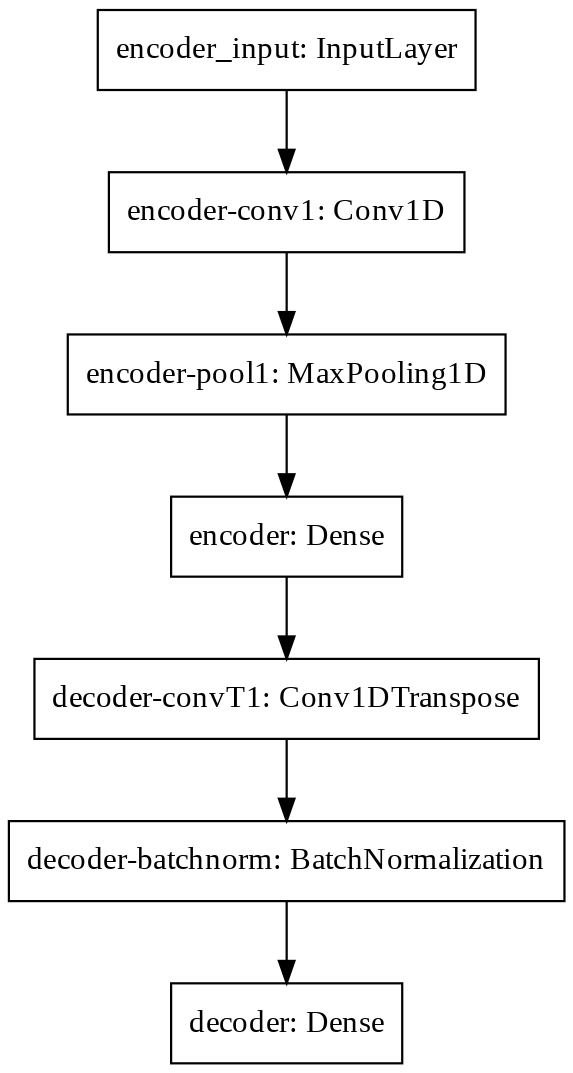

In [ ]:
inputs = Input(shape=(TIMESTEPS, 
                      N_FEATURES), 
               name='encoder_input')

def encoder(inp):
  '''
  Encoder.

  Input
  inp   A tensor of input data.

  Process
  Extract the essential features of the input as
  its encodings by filtering it through convolutional
  layer(s). Pooling can also be used to further
  summarize the features.

  A linearly activated dense layer is added as the
  final layer in encoding to perform any affine
  transformation required. The dense layer is not
  for any feature extraction. Instead, it is only
  to make the encoding and decoding connections
  simpler for training.

  Output
  encoding  A tensor of encodings.
  '''

  # Multiple (conv, pool) blocks can be added here
  conv1 = Conv1D(filters=N_FEATURES,
                 kernel_size=4,
                 activation='relu',
                 padding='same',
                 name='encoder-conv1')(inp)
  pool1 = MaxPool1D(pool_size=4,
                    strides=1,
                    padding='same',
                    name='encoder-pool1')(conv1)
  
  # The last layer in encoding
  encoding = Dense(units=N_FEATURES,
                   activation='linear',
                   activity_regularizer=
                    tf.keras.regularizers.L1(l1=0.01),
                   name='encoder')(pool1)
  
  return encoding

def decoder(encoding):
  '''
  Decoder.

  Input
  encoding    The encoded data.

  Process
  The decoding process requires a transposed 
  convolutional layer, a.k.a. a deconvolution 
  layer. Decoding must not be done with a 
  regular convolutional layer. A regular conv 
  layer is meant to extract a downsampled 
  feature map. Decoding, on the other hand, 
  is reconstruction of the original data from 
  the downsampled feature map. A regular 
  convolutional layer would try to extract 
  further higher level features from
  the encodings instead of a reconstruction.
  
  For a similar reason, pooling must not be 
  used in a decoder. A pooling operation is 
  for summarizing a data into a few summary
  statistics which is useful in tasks such as 
  classification. The purpose of decoding is 
  the opposite, i.e., reconstruct the original 
  data from the summarizations. Adding pooling 
  in a decoder makes it lose the variations 
  in the data and, hence, a poor reconstruction.

  If the purpose is only reconstruction, a 
  linear activation should be used in decoding. 
  A nonlinear activation is useful for
  predictive features but not for reconstruction.

  Batch normalization helps a decoder by 
  preventing the reconstructions
  from exploding.

  Output
  decoding    The decoded data.

  '''

  convT1 = Conv1DTranspose(filters=N_FEATURES,
                           kernel_size=4,
                           activation='linear',
                           padding='same',
                           name='decoder-convT1')(encoding)

  decoding = BatchNormalization(
      name='decoder-batchnorm'
  )(convT1)

  decoding = Dense(units=N_FEATURES,
                   activation='linear',
                   name='decoder')(decoding)
  
  return decoding

autoencoder = Model(inputs=inputs, 
                    outputs=decoder(encoder(inputs)))

autoencoder.summary()

# Plot the network structure
tf.keras.utils.plot_model(model=autoencoder, 
                          show_shapes=False, 
                          dpi=160)

In [ ]:
autoencoder.compile(loss='mean_squared_error', 
                    optimizer = 'adam')

history = autoencoder.fit(x=X_train_y0_scaled, 
                          y=X_train_y0_scaled, 
                          epochs=100, 
                          batch_size=128, 
                          validation_data=(X_valid_y0_scaled, 
                                           X_valid_y0_scaled),
                          verbose=1).history

Epoch 1/100
101/101 [==============================] - 4s 38ms/step - loss: 3.1838 - val_loss: 1.6138
Epoch 2/100
101/101 [==============================] - 4s 35ms/step - loss: 1.0715 - val_loss: 1.2308
Epoch 3/100
101/101 [==============================] - 4s 35ms/step - loss: 0.8191 - val_loss: 1.0489
Epoch 4/100
101/101 [==============================] - 4s 35ms/step - loss: 0.6967 - val_loss: 0.8912
Epoch 5/100
101/101 [==============================] - 4s 36ms/step - loss: 0.6506 - val_loss: 0.8225
Epoch 6/100
101/101 [==============================] - 4s 35ms/step - loss: 0.6025 - val_loss: 0.6632
Epoch 7/100
101/101 [==============================] - 4s 36ms/step - loss: 0.5654 - val_loss: 0.5733
Epoch 8/100
101/101 [==============================] - 5s 50ms/step - loss: 0.5329 - val_loss: 0.5548
Epoch 9/100
101/101 [==============================] - 4s 41ms/step - loss: 0.4983 - val_loss: 0.5214
Epoch 10/100
101/101 [==============================] - 4s 39ms/step - loss: 0.490

In [ ]:
autoencoder.save_weights('cnn-sparse-autoencoder.h5')

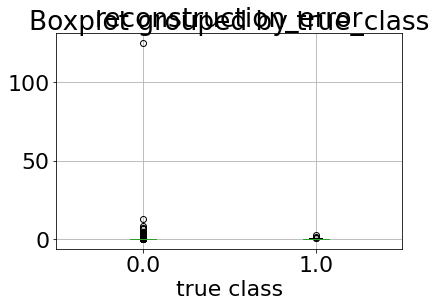

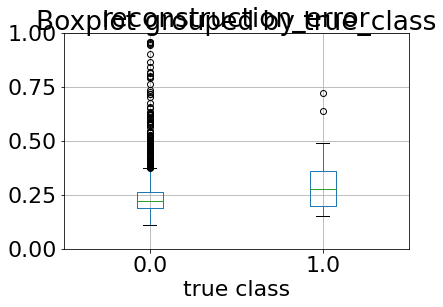

In [ ]:
error_vs_class_valid = rp.reconstructionerror_vs_class(model=autoencoder, 
                                                       sample=X_valid_scaled, 
                                                       y=y_valid)

plt, fig = rp.error_boxplot(error_vs_class=error_vs_class_valid)
fig.savefig('cnn-sparse-autoencoder-master-boxplot.pdf', bbox_inches='tight')

plt, fig = rp.error_boxplot(error_vs_class=error_vs_class_valid, ylim=[0.,1])
fig.savefig('cnn-sparse-autoencoder-zoomed-boxplot.pdf', bbox_inches='tight')

In [ ]:
errors_valid0 = rp.class_errors(error_vs_class=error_vs_class_valid, 
                                label=0)
errors_valid1 = rp.class_errors(error_vs_class=error_vs_class_valid, 
                                label=1)
rp.robust_stat_difference(z1=errors_valid0, z2=errors_valid1)

2.964472357872913

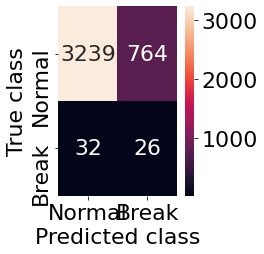

In [ ]:
error_vs_class_test = rp.reconstructionerror_vs_class(model=autoencoder, 
                                                      sample=X_test_scaled, 
                                                      y=y_test)
conf_matrix, fig = rp.model_confusion_matrix(
    error_vs_class=error_vs_class_test, 
    threshold=errors_valid1.quantile(0.50))
fig.savefig('cnn-sparse-autoencoder-baseline-conf-matrix.pdf', bbox_inches='tight')

# Convolutional Encoded Classifier

## Encoding Model

In [ ]:
encoder_model = Model(inputs=autoencoder.inputs, 
                      outputs=autoencoder.get_layer('encoder').output)
X_train_y0_encoded_features = pd.DataFrame(dp.flatten(encoder_model.predict(X_train_y0_scaled)))
X_train_y0_encoded_features

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68
0,-0.001331,0.001008,0.000297,-0.001284,0.000485,-0.001056,-0.002393,0.000868,0.002491,0.002799,-0.000201,-0.001307,-0.000316,-0.001018,-0.001045,0.000414,-0.001369,0.000409,0.000602,-0.003738,0.001007,0.001238,-0.000555,-0.000887,0.000540,0.000731,0.001242,-0.000098,0.000208,-7.826730e-04,-0.000893,0.000021,0.000365,-0.001477,-0.001080,0.002125,-0.000431,0.000626,-0.000204,0.001503,-0.001048,-0.000269,-0.001128,0.003119,-0.000402,0.000178,-0.000781,-0.000424,0.000903,-0.009369,0.002768,0.001170,-0.001582,0.001101,-0.001706,-0.000091,-0.005400,0.000601,0.001082,-0.000233,-0.000045,0.000268,0.000824,0.002958,-0.000028,-0.001380,0.000567,0.000152,0.001126
1,-0.000367,-0.000057,0.000553,-0.001005,0.000073,0.000991,-0.001433,0.001639,0.001208,0.000703,-0.000135,-0.001660,0.000116,-0.002004,-0.001612,0.000541,-0.001707,0.000487,0.000504,-0.005261,-0.000538,-0.000736,0.075924,-0.001389,0.000826,0.000243,0.002401,-0.001659,0.000713,6.167032e-04,0.000752,-0.001155,-0.000002,0.004459,0.000130,0.000337,-0.002536,0.000980,0.000395,0.002309,0.000665,-0.000415,0.001801,-0.001838,0.001137,-0.001298,0.000560,0.000301,0.004132,-0.001449,0.004042,0.001479,0.001012,0.001598,0.000869,-0.000581,-0.000266,0.000547,-0.000713,-0.001450,0.000534,-0.001127,0.000161,0.001155,-0.002232,0.000911,0.000297,-0.000051,0.000858
2,-0.001298,-0.000306,0.001095,0.002734,0.002897,0.000695,0.000393,0.000887,0.001147,-0.012540,-0.000021,-0.001430,-0.000510,-0.000621,0.000285,-0.000185,0.000181,0.001456,0.000511,-0.000245,-0.002103,0.000155,-0.000607,0.000594,-0.000725,0.001189,-0.000495,0.002572,-0.001726,-3.081860e-04,-0.000333,-0.006171,-0.001059,-0.000346,0.000330,-0.000009,0.000265,0.017157,-0.001426,0.001596,0.000099,0.000812,-0.000440,0.000766,-0.000879,0.000472,-0.000785,0.000384,-0.000470,0.001915,-0.000462,0.000266,-0.000540,0.001648,-0.002368,-0.000366,0.000295,0.000084,0.002685,-0.000056,-0.000840,-0.000028,-0.001829,-0.001120,-0.000028,-0.000102,-0.000156,-0.001136,-0.000301
3,-0.001386,0.001515,0.000894,-0.005358,0.001380,-0.003374,0.000736,0.000216,-0.000597,-0.000423,-0.000651,-0.000536,-0.000161,-0.001321,0.001589,-0.000149,-0.001435,0.001342,0.000117,-0.001416,0.000060,0.000423,-0.000669,0.001797,0.001038,-0.002386,-0.000665,-0.000528,0.003252,-4.347329e-03,-0.000827,0.001078,-0.000259,-0.001719,-0.000071,0.004244,0.001308,0.001823,-0.012164,-0.001202,-0.003348,0.000820,-0.000765,0.003476,-0.001067,0.001569,0.000088,0.000382,-0.001031,0.001000,0.001576,-0.000116,-0.001858,0.000256,0.003232,0.002149,0.000045,0.000143,0.002952,-0.000700,0.000884,0.001939,-0.001356,-0.000084,0.005645,-0.001302,0.000820,-0.000087,0.000681
4,-0.001673,-0.000238,0.000555,0.002977,0.001828,0.000354,-0.001360,0.000785,0.001986,-0.001801,-0.000341,-0.000607,0.000099,-0.001869,-0.001686,-0.000395,0.000436,0.000170,0.000466,-0.002103,0.000688,0.000049,-0.000372,0.002414,-0.000413,0.003520,-0.000206,0.001091,-0.000430,-7.888302e-07,-0.000268,-0.001050,0.000765,0.003270,-0.000723,0.000027,-0.001562,-0.001560,0.005138,0.000600,0.000717,-0.000325,0.000365,-0.001132,-0.000106,-0.000297,0.001900,0.000214,0.002072,-0.006242,0.000179,-0.000650,-0.000841,0.000400,-0.000399,-0.005746,-0.001826,-0.000022,-0.002100,0.000150,-0.000776,-0.001190,-0.000267,0.004009,0.001184,0.000042,0.001739,-0.001084,-0.000172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12813,-0.001386,-0.000267,0.000137,-0.001674,0.000790,-0.001308,0.000424,0.001035,0.002967,0.000528,-0.000286,-0.000184,-0.000475,-0.002127,-0.003310,0.000022,-0.000705,0.000028,0.000566,-0.009401,0.000040,0.000133

## Encode the data sets

In [ ]:
X_train_encoded_features = encoder_model.predict(X_train_scaled)
X_valid_encoded_features = encoder_model.predict(X_valid_scaled)
X_test_encoded_features = encoder_model.predict(X_test_scaled)

## Classifier Model

In [ ]:
model = Sequential()
model.add(Input(shape=(X_train_encoded_features.shape[1], 
                       X_train_encoded_features.shape[2]), 
                name='input'))
model.add(Conv1D(filters=16, 
                 kernel_size=4,
                 activation='relu', 
                 padding='valid'))
model.add(MaxPool1D(pool_size=4, 
                    padding='valid'))
model.add(Flatten())
model.add(Dense(units=16, 
                activation='relu'))
model.add(Dense(units=1, 
                activation='sigmoid', 
                name='output'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_2 (Conv1D)            (None, 17, 16)            4432      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 4, 16)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 1)                 17        
Total params: 5,489
Trainable params: 5,489
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[
                  'accuracy',
                  tf.keras.metrics.Recall(),
                  pm.F1Score(),
                  pm.FalsePositiveRate()
              ])
history = model.fit(x=X_train_encoded_features,
                    y=y_train,
                    batch_size=128,
                    epochs=150,
                    validation_data=(X_valid_encoded_features, y_valid),
                    verbose=1).history

Epoch 1/150
102/102 [==============================] - 1s 10ms/step - loss: 0.3818 - accuracy: 0.9808 - recall_2: 0.0057 - f1_score: 0.0080 - false_positive_rate: 0.0059 - val_loss: 0.0892 - val_accuracy: 0.9886 - val_recall_2: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0000e+00
Epoch 2/150
102/102 [==============================] - 1s 7ms/step - loss: 0.0748 - accuracy: 0.9866 - recall_2: 0.0000e+00 - f1_score: 0.0000e+00 - false_positive_rate: 0.0000e+00 - val_loss: 0.0625 - val_accuracy: 0.9886 - val_recall_2: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0000e+00
Epoch 3/150
102/102 [==============================] - 1s 7ms/step - loss: 0.0706 - accuracy: 0.9866 - recall_2: 0.0000e+00 - f1_score: 0.0000e+00 - false_positive_rate: 0.0000e+00 - val_loss: 0.0619 - val_accuracy: 0.9886 - val_recall_2: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_false_positive_rate: 0.0000e+00
Epoch 4/150
102/102 [==============================] - 1s 7ms/step

## Results

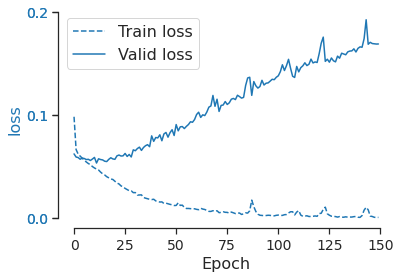

In [ ]:
plt, fig = sp.plot_metric(history, metric='loss')
fig.savefig('sparse_cnn_encoder_classifier_loss.pdf', bbox_inches='tight')

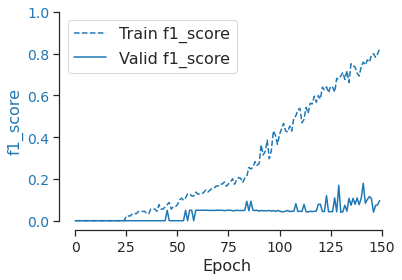

In [ ]:
plt, fig = sp.plot_metric(history, metric='f1_score', ylim=[0., 1.])
# fig.savefig('sparse_cnn_encoder_classifier_f1_score.pdf', bbox_inches='tight')

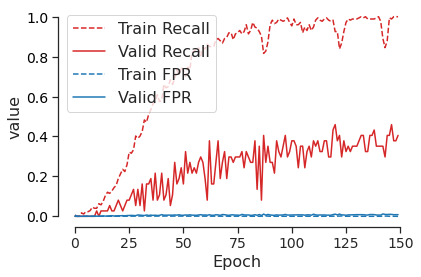

In [ ]:
plt, fig = sp.plot_model_recall_fpr(history)
# fig.savefig('sparse_cnn_encoder_classifier_recall_fpr.pdf', bbox_inches='tight')